# Create Pyspark project for simply EDA 

#initiate findspark

In [50]:
import findspark
findspark.init()

In [51]:
#imports library

In [52]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan, when, count, col



In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [55]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()

In [56]:
spark

In [57]:
sc = spark.sparkContext
sc


<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [58]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

#Load data

In [59]:
HOUSING_DATA = '../MLProblemwithPyspark/Data/cal_housing.data'

In [63]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [64]:
# Load housing data
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()
#df = spark.read.csv(path=HOUSING_DATA, header=True)
housing_df.printSchema()


root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



#Exploratory data analysis part 1- for finding no.of columns,rows, shape, schema,datatype,top 5 rows,count null values, drop duplicates and summary table

In [65]:
def EDA(x):
    columns=x.columns
    ncolumn=len(columns)
    rows=x.count()
    print("column name :", columns)
    print("total columns :", ncolumn)
    print("total rows :", rows)
    print("shape of dataframe :", [ncolumn, rows])
  #  print("schema :", x.printSchema())
    print("datatype:",  x.dtypes)
    print("+-------------------+--------------+------------------+---------------+")
    print("top 5 rows:")
    print(x.show(5))
    print("total null values in columns", x.select([count(when(isnan(c), c)).alias(c) for c in housing_df.columns]).show()
   )
    print("Distinct count before dropping duplicates: ",x.distinct().count())  
    df2 = x.dropDuplicates()
    print("Distinct count after dropping duplicates: ",df2.count())
    print("Summary statistics :")
    print("+----------------+------------+-----------------+------------+------------+")
    (x.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())
   # df2.describe().iloc[1:].applymap('{:.6f}'.format).show()

    

In [66]:
EDA(housing_df)

column name : ['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv']
total columns : 9
total rows : 20640
shape of dataframe : [9, 20640]
datatype: [('long', 'float'), ('lat', 'float'), ('medage', 'float'), ('totrooms', 'float'), ('totbdrms', 'float'), ('pop', 'float'), ('houshlds', 'float'), ('medinc', 'float'), ('medhv', 'float')]
+-------------------+--------------+------------------+---------------+
top 5 rows:
+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280

In [67]:
# EDA part 2- Quartile1, Quartile2, Quartile3, IQR, Lower range and Upper range

In [68]:
def EDA2(df):
    quartile=df.approxQuantile(df.columns, [0.25,0.5, 0.75], 0) # no need to import DataFrameStatFunctions
    df1 = spark.createDataFrame(quartile)
    print(df.columns)
    #df1 = df1.withColumn("name", df.columns)
    schema1 = StructType([
    StructField("_1", FloatType(), nullable=True),
    StructField("_2", FloatType(), nullable=True),
    StructField("_3", FloatType(), nullable=True)])
    df2=spark.createDataFrame(quartile, schema=schema1)
    #df2 = df2.withColumn("name", df.columns)
    Q1=df2.select("_1")
    #print("Quartile1/Q1:", Q1.show())
    Median=df2.select("_2")
    #print("Quartile2/Q2:", Median.show())
    Q3=df2.select("_3")
    #print("Quartile3/Q3:", Q3.show())
    #df2 = df2.withColumn('column', (df.columns ) )
    df2 = df2.withColumn('IQR', ( df2['_3'] - df2['_1'] ) )
    df2 = df2.withColumn('LowerRegion', (df2['_1']-(df2['IQR']*1.5) ) )
    df2 = df2.withColumn('UpperRegion', (df2['_3']+(df2['IQR']*1.5) ) ) 
    #df2 = df2.withColumn('Outlier', when(((df2['_1'] < df2['LowerRegion']) & (df2['_3'] >= df2['UpperRegion'])), 'outlier').otherwise('no outlier')) 
    df2.show()

In [69]:
EDA2(housing_df)

['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv']
+--------+--------+--------+---------+-------------------+-------------------+
|      _1|      _2|      _3|      IQR|        LowerRegion|        UpperRegion|
+--------+--------+--------+---------+-------------------+-------------------+
|  -121.8| -118.49| -118.01| 3.790001|-127.48500442504883|-112.32500076293945|
|   33.93|   34.26|   37.71|3.7799988|  28.26000213623047|  43.37999725341797|
|    18.0|    29.0|    37.0|     19.0|              -10.5|               65.5|
|  1447.0|  2127.0|  3148.0|   1701.0|            -1104.5|             5699.5|
|   295.0|   435.0|   647.0|    352.0|             -233.0|             1175.0|
|   787.0|  1166.0|  1725.0|    938.0|             -620.0|             3132.0|
|   280.0|   409.0|   605.0|    325.0|             -207.5|             1092.5|
|  2.5625|  3.5347|  4.7431|2.1806002|-0.7084002494812012|  8.014000415802002|
|119600.0|179700.0|264700.0| 145100.0|     

In [70]:
#EDA Part3- Standard deviation, variation, skewness and kurtosis

In [71]:
from pyspark.sql import functions as f
def deviation(df):
    for i in range(0,9) :
        #var=0
        var=df.agg(f.variance(df.columns[i]), f.stddev(df.columns[i]), f.kurtosis(housing_df.columns[i]), f.skewness(housing_df.columns[i]))
        print(var.show())

In [72]:
deviation(housing_df)

+-----------------+-----------------+------------------+-------------------+
|   var_samp(long)|stddev_samp(long)|    kurtosis(long)|     skewness(long)|
+-----------------+-----------------+------------------+-------------------+
|4.014139444939737|2.003531742932898|-1.330120805638247|-0.2977795920144634|
+-----------------+-----------------+------------------+-------------------+

None
+-----------------+-----------------+------------------+------------------+
|    var_samp(lat)| stddev_samp(lat)|     kurtosis(lat)|     skewness(lat)|
+-----------------+-----------------+------------------+------------------+
|4.562292572203486|2.135952380602968|-1.117779696849667|0.4659191432830098|
+-----------------+-----------------+------------------+------------------+

None
+----------------+-------------------+-------------------+--------------------+
|var_samp(medage)|stddev_samp(medage)|   kurtosis(medage)|    skewness(medage)|
+----------------+-------------------+-------------------+-----

#Convert data into Pandas dataframe

In [73]:
pandasDF = housing_df.toPandas()
pandasDF.head(5)

,long,lat,medage,totrooms,totbdrms,pop,houshlds,medinc,medhv
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [74]:
#plot Boxplot for visualize outliers in data

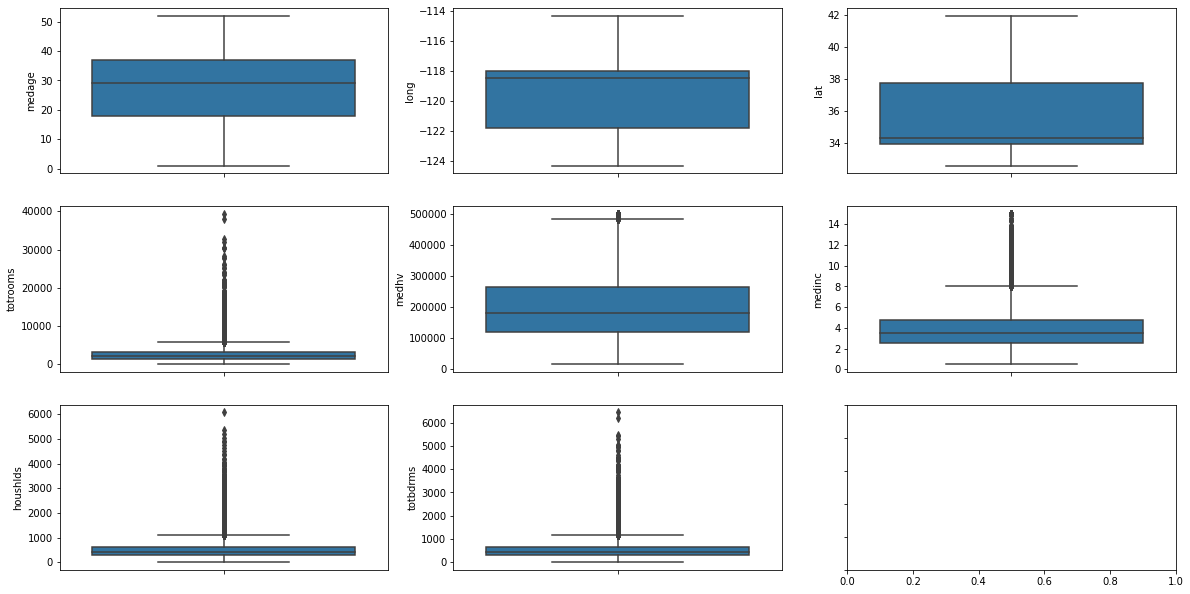

In [75]:
#long', 'lat', 'medage', 'totrooms', 'pop', 'medinc', 'medhv']
#fig, (ax1, ax2) = plt.subplots(3, 3, figsize=(22, 12), sharey=True)
fig, ax = plt.subplots(3, 3,figsize=(20, 10), sharex=True, sharey=True)
#ax1 = fig.add_subplot(211)
ax1 = plt.subplot(3, 3, 1, frameon=True)
ax1 = sns.boxplot(y=pandasDF.medage)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=25)
#
ax2 = plt.subplot(3, 3, 2, frameon=True)
ax2 = sns.boxplot(y=pandasDF.long)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
#plt.show()
ax3 = plt.subplot(3, 3, 3, frameon=True)
ax3 = sns.boxplot(y=pandasDF.lat)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
#plt.show()
ax4 = plt.subplot(3, 3, 4, frameon=True)
ax4 = sns.boxplot(y=pandasDF.totrooms)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
#plt.show()
ax5 = plt.subplot(3, 3,5, frameon=True)
ax5 = sns.boxplot(y=pandasDF.medhv)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
ax6 = plt.subplot(3, 3,6, frameon=True)
ax6 = sns.boxplot(y=pandasDF.medinc)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
ax7 = plt.subplot(3, 3, 7, frameon=True)
ax7 = sns.boxplot(y=pandasDF.houshlds)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
ax8 = plt.subplot(3, 3,8, frameon=True)
ax8 = sns.boxplot(y=pandasDF.totbdrms)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=20)
plt.savefig('boxplot.png')

plt.show()

#Remove Outlies

In [76]:
#print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))

In [79]:
from pyspark.sql.types import Row

# Importing required libraries for VIF Calculation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
# ------------------------------------------------------------------------------
# Calculating VIF
# Assigning the threshold for VIF in the first line
# This may be changed to any other value as per requirement
# ------------------------------------------------------------------------------
vif_threshold = 5 #Threshold for VIF

def vif_cal_iter(inputdata,vif_threshold):
  xvar_names = inputdata.columns
  global vif_max
  global colnum_max
  colnum_max = 10000 # Initialising with a fake value
  vif_max = vif_threshold + 1
  def vif_cal(inputdata, xvar_names, vif_max, colnum_max, vif_threshold):
    print("Dimension of table at this level")
    print("================================")
    print(inputdata.count(), len(inputdata.columns))
    print("List of X Variables")
    print("===================")
    print(xvar_names)
    vif_max = vif_threshold
    for i in range(2,len(xvar_names)):
      train_t = inputdata.rdd.map(lambda x: [Vectors.dense(x[2:i]+x[i+1:]), x[i]]).toDF(['features', 'label'])
      lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
      lr_model = lr.fit(train_t)
      predictions = lr_model.transform(train_t)
      evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
      r_sq=evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
      vif=1/(1-r_sq)
      if vif_max < vif:
        vif_max = vif
        colnum_max = i
    return vif_max, colnum_max
  while vif_max > 5:
    vif_max, colnum_max = vif_cal(inputdata, xvar_names, vif_max, colnum_max, vif_threshold)
    if vif_max > vif_threshold:
        print("Start of If Block")
        inputdata = inputdata.drop(inputdata[colnum_max])
        xvar_names = inputdata.columns
        print("Dimension of table after this iteration")
        print("=======================================")
        print(inputdata.count(), len(inputdata.columns))
        print("List of X Variables remaining")
        print("=============================")
        print(xvar_names)
  else:
    return inputdata



In [80]:
train = vif_cal_iter(housing_df,vif_threshold)
print(train.count(), len(train.columns))

Dimension of table at this level
20640 9
List of X Variables
['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv']
Start of If Block
Dimension of table after this iteration
20640 8
List of X Variables remaining
['long', 'lat', 'medage', 'totrooms', 'pop', 'houshlds', 'medinc', 'medhv']
Dimension of table at this level
20640 8
List of X Variables
['long', 'lat', 'medage', 'totrooms', 'pop', 'houshlds', 'medinc', 'medhv']
Start of If Block
Dimension of table after this iteration
20640 7
List of X Variables remaining
['long', 'lat', 'medage', 'totrooms', 'pop', 'medinc', 'medhv']
Dimension of table at this level
20640 7
List of X Variables
['long', 'lat', 'medage', 'totrooms', 'pop', 'medinc', 'medhv']


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 605.0 failed 1 times, most recent failure: Lost task 0.0 in stage 605.0 (TID 2197, localhost, executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:170)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:97)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:117)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:109)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:164)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1925)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1913)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1912)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1912)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2146)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2095)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2084)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:759)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor208.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:170)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:97)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:117)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:109)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:164)
	... 14 more


In [81]:
#Correlation matrix and plot Heatmap

In [82]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)
    matrix1 = Correlation.corr(df_vector, vector_col).collect()[0][0]
    corrmatrix = matrix1.toArray().tolist()
    #corrmatrix = matrix.toArray().tolist()
    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    attr=df.columns
    #fig=plt.figure(334)
    #ax=fig.add_subplot(111)
    fig, ax = plt.subplots(1,1,figsize=(10, 10), sharex=True, sharey=True)
    ax.set_title("Heatmap for the data")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

d:\a\cc\ana\envs\myenv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\a\cc\ana\envs\myenv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


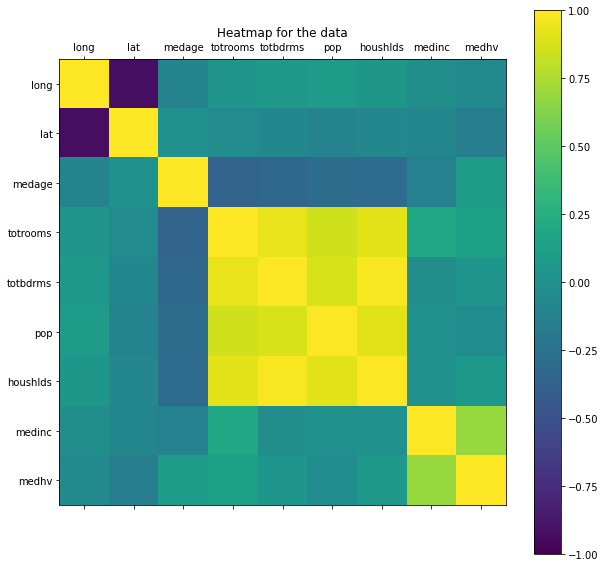

,long,lat,medage,totrooms,totbdrms,pop,houshlds,medinc,medhv
long,1.000000,-0.924664,-0.108197,0.044568,0.068378,0.099773,0.055310,-0.015176,-0.045967
lat,-0.924664,1.000000,0.011173,-0.036100,-0.066318,-0.108785,-0.071035,-0.079809,-0.144160
medage,-0.108197,0.011173,1.000000,-0.361262,-0.320485,-0.296244,-0.302916,-0.119034,0.105623
totrooms,0.044568,-0.036100,-0.361262,1.000000,0.929893,0.857126,0.918484,0.198050,0.134153
totbdrms,0.068378,-0.066318,-0.320485,0.929893,1.000000,0.878026,0.979829,-0.008093,0.050594
pop,0.099773,-0.108785,-0.296244,0.857126,0.878026,1.000000,0.907222,0.004834,-0.024650
houshlds,0.055310,-0.071035,-0.302916,0.918484,0.979829,0.907222,1.000000,0.013033,0.065843
medinc,-0.015176,-0.079809,-0.119034,0.198050,-0.008093,0.004834,0.013033,1.000000,0.688075
medhv,-0.045967,-0.144160,0.105623,0.134153,0.050594,-0.024650,0.065843,0.688075,1.000000


In [79]:
correlation_matrix(housing_df, housing_df.columns, method='pearson')